# Happy Markov Models (HMM)

In this article, we are going to generate new words that statistically sound positive. To do so, we are going to use a set of words gathered from a large number of positive reviews found on the internet [1, 2] and using a Hidden Markov Model (HMM).

With HMM we will be able to create a language model which will define how positive words are composed, at least how they are statistically composed.

To get things even simpler, we are going to use an existing Python package to work with HMMs developed by my own [3].

## What are Markov Chains and HMMs?

Markov Chains models the way of moving from a determined state $a$ to another state $b$. Each transition has a probability $p_{ab}$ associated meaning how likely is moving from $a$ to $b$. A Markov chain makes a very strong assumption that if we want to predict the future in the sequence, all that matters is the current state (See Equation 1)[4]. 

$P(q_i=a|q_{i-1}) $

*Equation 1: Markov assumption*

Figure 1 shows an example of how a Markov Chain looks like.

<img src="https://raw.githubusercontent.com/Guillem96/jax-hidden-markov-model/master/img/mdp.jpg" width=400/>

*Figure 1. Markov chain (Slide comming from Berkeley Reinforcement Learning course)*

The HMM is based on augmenting the Markov chain framework. A Markov chain is useful when we need to compute a probability for a sequence of observable events, but sometimes we cannot see what is happening under the hoods. Imagine, that every day, we see a different animal, for instance, the first day we see an ant, the second day a snail, and finally a white fox (Figure 2). What is happening here? Does seeing an ant modifies the probability a snail the following day? It doesn't, what is modifying the probabilities is the weather. Depending on if it is sunny, rainy or snowy we the probabilities of seeing a specific animal varies.

![HMM Animals example](https://raw.githubusercontent.com/Guillem96/jax-hidden-markov-model/master/img/HMM%20Example.png)

*Figure 2. HMM animals example*

An HMM allows us to talk about both observed events(like the animals) and hidden events (like like the weather) that we think of as causal factors in our probabilistic model.  An HMM is specified bythe following components:

- $Q = q_1, q_2, q_3, ...$: The set of possible hidden states (Sunny, rainy and snowy)
- $O = o_1, o_2, o_3, ...$: A sequence of **observations** sampled from a vocabulary $V$(White Fox, Snail and Ant)
- $\pi = \pi_1, \pi_2, \pi_3,...$: The probability distribution of starting at a determined hidden state.
- $A = a_{ij}$: **Transition probabilities**. Matrix that at position $ij$ we find the probability of going from $q_i$ to $q_j$
- $ B = b_i(o_t) $: **Emission probabilities**. Probability of observing $o$ being at state $i$ at timestep $t$

As Linus would say: *Talk is cheap, show me code*. And this is exactly what I am going to show you. We are going to learn how to formalize the animals example with my own HMM Python package.

In [1]:
import hmm
import jax.numpy as np

# Decalre the name of the possible Hidden States Q
Q_names = ['Sunny', 'Rainy', 'Snowy']

# Define the vocabulary of Observations
V = ['Ant', 'Snail', 'White Fox']

# Define transition probs
A = np.array([[0.6, 0.3, 0.1],
              [0.4, 0.4, 0.2],
              [0.1, 0.4, 0.5]])

B = np.array([[0.8, 0.2, 0.0],
              [0.1, 0.6, 0.3],
              [0.0, 0.1, 0.9]])

pi = np.array([.3, .3, .4])

animals_hmm = hmm.HiddenMarkovModel(A=A, B=B, pi=pi)

/mnt/c/Users/Guillem/Desktop/projects/jax/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


May be at this point the code above is a bin unclear, but if we plot what we have declared the things will become a lot clearer.

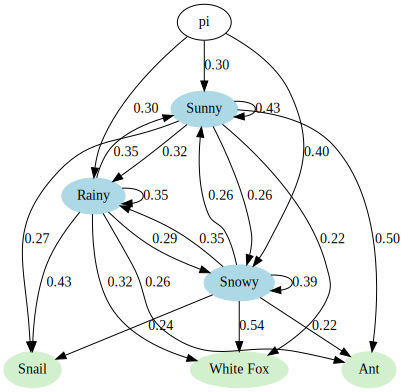

In [2]:
animals_hmm.draw(Q_names, V)

Looking at the plot we can see the probabilities ($\pi$) of starting at specific hidden state, the transition probabilites and the emission probabilities being at each hidden state.

That's all for the Hidden Markov Models introduction. If you want to learn more about them, IMO this [4] notes are a pretty good resource.

Now lets move on to our use case of creating positive *soundish* words.

## Preprocessing corpus

Since our goal is to generate new words, we should work at character level, meaning that characters are going to be the observations and the total number of timesteps, is going to be the word length. For example, a word $W_l$ of length $l$ will be composed of $l$ letters $o_1, o_2, ..., o_l$, in other words, $Wl$ is going to be a sequence of $l$ observations.

Now imagine that the generated word is "hello". In this case, we have:

$W_5 = o_1, o_2, ..., o_5$ where 

$o_1 = h, o_2 = e, o_3 = l, o_4 = l, o_5 = o$

Similar to other Natural Language Processing (NLP) tasks, we cannot work using characters neither words, we have to convert them using a vocabulary.

In [3]:
import string

letters = string.ascii_lowercase + '-'
letter2idx = {o: i for i, o in enumerate(letters, start=1)} # Reserve 0 for padding

print('hello =', ','.join(str(letter2idx[o]) for o in 'hello'))

hello = 8,5,12,12,15


Once we have a way of converting words into numbers, we can load the dataset and convert some random existing words.  

In [4]:
import random

with open('data/words.txt') as f:
    dataset = [w.strip() for w in f.readlines() 
               if w.strip() and not w.startswith(';')]

print('Number of words:', len(dataset))
print(random.sample(dataset, 5))

Number of words: 2005
['humourous', 'appreciatively', 'amply', 'pampers', 'nicer']


In [5]:
def word2idx(word):
    return [letter2idx[o] for o in word]

random_words = random.sample(dataset, 5)
for w in random_words:
    print(f'{w} =', ','.join(map(str, word2idx(w))))    

pride = 16,18,9,4,5
considerate = 3,15,14,19,9,4,5,18,1,20,5
skillful = 19,11,9,12,12,6,21,12
elegance = 5,12,5,7,1,14,3,5
cute = 3,21,20,5


Now we can easily convert a word to numbers. Pretty interesting, isn't it? But we want to go a bit further. 

Usually, Machine Learning (ML) models are trained using *batches* of data, and HMMs are not different. So, before moving forward, we need a function that samples $n$ words and packs them into a single tensor. Also, if you are familiar with sequences, you should now that to pack heterogeneous sequences into a single tensor they must have the same size, in other words, they all need to be of size $n$. To achieve that, we usually pad sequences to match the larger sequence inside the batch, which exactly $n$ elements. 

In [6]:
def sampler(batch_size=32, pad_val=0):
    batch = random.sample(dataset, batch_size)
    max_len = max(len(o) for o in batch)
    padded_batch = []
    for b in batch:
        offset = max_len - len(b)
        padded_batch.append(word2idx(b) + [pad_val] * offset)
    
    return np.array(padded_batch)

sample_batch = sampler()
print('Batch shape [N_SAMPLES, SEQUENCE_LEN]:', sample_batch.shape)

Batch shape [N_SAMPLES, SEQUENCE_LEN]: (32, 13)


We are done here. Let's move on to the training part.

## Training an HMM

In this section, we are going to train an HMM from scratch using the package seen above. 

First of all, we are going to declare an HMM having at least eight possible hidden states and having as many observations as the length of our vocabulary.

> Note that the number of hidden states is arbitrary. With a bigger number of hidden states, we will tend to higher variances (probably overfit), and with low values for hidden states will have a higher bias (higher probability of underfitting). Summarizing, the number of hidden states is an hyperparameter, and you have to play with it in order to improve performance.

In [7]:
import jax

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)

words_hmm = hmm.HiddenMarkovModel.random_init(
    key, n_hidden_states=64, n_observations=len(letters) + 1)

To train our HMM, what we need to do, is to tweak the parameters ($A$, $B$ and $\pi$) so they maximize the probability of training words to appear.

If we now sample a word, we are going to see that it does not make any sense. This is because HMM is randomly intialized.

In [8]:
def decode_word(indices):
    vocab = ['<pad>'] + list(letters)
    return ''.join(vocab[i] for i in indices)

key, subkey = jax.random.split(key)
generated_word = words_hmm.sample(subkey, timesteps=5) # Sample a word with 5 characters
print('Generated word:', decode_word(generated_word.reshape(-1)))

Generated word: qevc-


In order to create, words with sense, or at least words pretending to have sense, we are going to maximize the probability of training words. To do so, we are going to use Stochastic Gradient Descent (SGD). More precicely, we are going to compute the gradients of the HMM parameters with respect of Negative Log Likelihood (NLL), and substract a small amount of the gradient to our parameters to maximize the training words likelihood.

$w_{t+1} = w_t - \alpha \frac{\partial L(w_t)}{\partial w_t}$

where $w$ are the HMM parameters and $L$ is the $NLL$.

$NLL = \frac{\sum_{n}{-\log p_i}}{n}$

where $p$ is the probability of a given training word.

Natively, my `hmm` package does not support *batching* with `likelihood` method. Luckily, JAX allow us to vectorize a function by just decorating it with `jax.vmap`. Also, `hmm` module, does not provide a simple way of computing the gradients of the HMM parameters with respect to an error function, but again, JAX provides the decorator `grad` or `value_and_grad` to automatically compute the derivatives of standard python code.

In [9]:
from functools import partial
import hmm.functional as F

v_likelihood = jax.vmap(F.likelihood, in_axes=(None, 0))

# Computes the NLL given the HMM and training words
def forward(hmm, words):
    # hmm package works with log probabilities,
    # so likelihood method returns the log probability instead of the *standard one*
    log_prob = v_likelihood(hmm, words)
    # To compute NLL we just have to neg the probability returned from the 
    # likelihood method
    return -log_prob.mean()

# Partial derivative of first arg (HMM params)
backward = jax.value_and_grad(forward)

If we now call `backward`, the function will return us the loss value and the gradients.

In [10]:
sample_batch = sampler(batch_size=4)
losses, grads = backward(words_hmm, sample_batch)
print('Loss:', losses)

Loss: 33.322784


If we apply a simple SGD step with a pretty high learning rate $\alpha$, we are going to see how the loss decreases.

In [11]:
alpha = 1e-1
words_hmm = words_hmm - grads * alpha
losses, grads = backward(words_hmm, sample_batch)
print('Loss:', losses)

Loss: 33.311375


Reapeat SGD for 1000 steps.

In [ ]:
alpha = 1e-2
running_loss = 0
training_steps = 5000

for step in range(training_steps):
    loss, grads = backward(words_hmm, sampler())
    words_hmm = words_hmm - grads * alpha
    running_loss += loss
    
    if (step + 1) % 10 == 0:
        mean_loss = running_loss / step
        print(f'Step [{step}/{training_steps}] Loss: {mean_loss:.4f}')

Step [9/5000] Loss: 52.9000
Step [19/5000] Loss: 49.2192
Step [29/5000] Loss: 48.6336
Step [39/5000] Loss: 48.4212
Step [49/5000] Loss: 48.4863
Step [59/5000] Loss: 48.4650
Step [69/5000] Loss: 48.6809
Step [79/5000] Loss: 48.2119
Step [89/5000] Loss: 47.8807
Step [99/5000] Loss: 47.5494
Step [109/5000] Loss: 47.3936
Step [119/5000] Loss: 47.2317
Step [129/5000] Loss: 47.1183
Step [139/5000] Loss: 47.0642
Step [149/5000] Loss: 46.8623
Step [159/5000] Loss: 46.7237
Step [169/5000] Loss: 46.6001
Step [179/5000] Loss: 46.6507
Step [189/5000] Loss: 46.6429
Step [199/5000] Loss: 46.4572
Step [209/5000] Loss: 46.3333
Step [219/5000] Loss: 46.1755
Step [229/5000] Loss: 46.1553
Step [239/5000] Loss: 46.2286
Step [249/5000] Loss: 46.1521
Step [259/5000] Loss: 46.1531
Step [269/5000] Loss: 46.1175
Step [279/5000] Loss: 46.1050
Step [289/5000] Loss: 46.0712
Step [299/5000] Loss: 46.0073
Step [309/5000] Loss: 45.9971
Step [319/5000] Loss: 45.9569
Step [329/5000] Loss: 45.9082
Step [339/5000] Loss:

In [ ]:
key, subkey = jax.random.split(key)
generated_word = words_hmm.sample(subkey, timesteps=5) # Sample a word with 5 characters
print('Generated word:', decode_word(generated_word.reshape(-1)))

## References

[1] Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews." 
       Proceedings of the ACM SIGKDD International Conference on Knowledge 
       Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle, 
       Washington, USA, 

[2] Bing Liu, Minqing Hu and Junsheng Cheng. "Opinion Observer: Analyzing 
       and Comparing Opinions on the Web." Proceedings of the 14th 
       International World Wide Web conference (WWW-2005), May 10-14, 
       2005, Chiba, Japan.

[3] Guillem96 - [Implementation of Hidden Markov Models using JAX](https://github.com/Guillem96/jax-hidden-markov-model)

[4] Daniel Jurafsky & James H. Martin - [Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/A.pdf)